In [1]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel
from darts.metrics import mape, r2_score, mse, mae
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, EfficientFrontier
import warnings

In [2]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))

In [3]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [4]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()

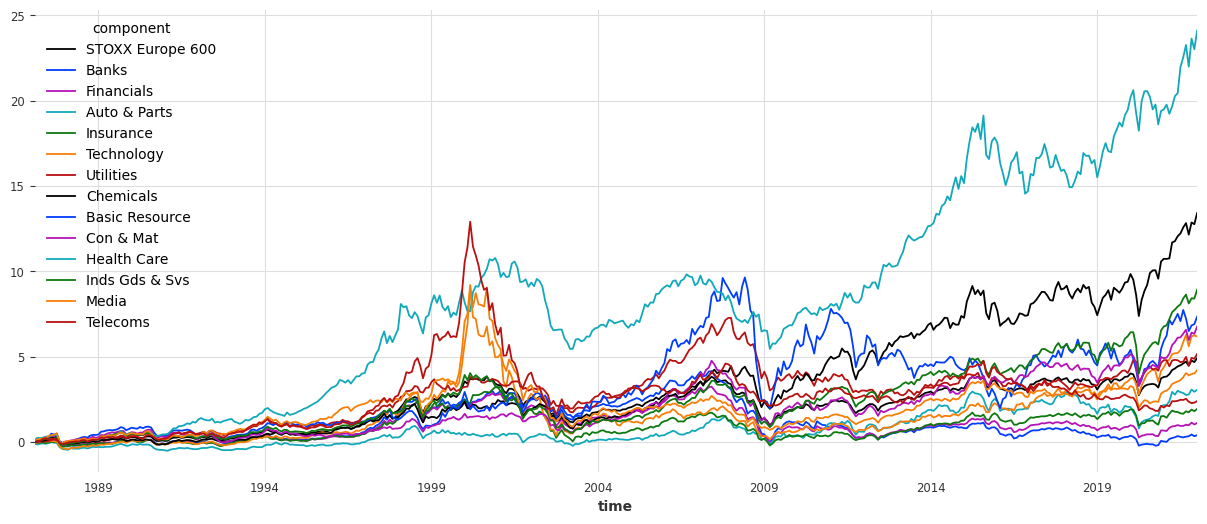

In [5]:
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

cum_returns_portfolio = cum_returns

# plot the cumulative returns
fig, ax = plt.subplots(figsize=(15, 6))
cum_returns.plot(ax=ax);

In [6]:
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)

In [7]:
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

In [8]:
# show length of train and test set
print('Length of train set: {}, length of test set: {}.'.format(len(train), len(test)))

Length of train set: 336, length of test set: 84.


## Benchmark Portfolios

Our main benchmark is the STOXX Europe 600 Index. Furthermore, we expand the benchmarks by computing the equal weighted portfolio and portfolio based on historical averages.

### Equal Weighted Portfolio

In [9]:
# create a list of the column names
col_list = list(cum_returns.columns)[1:]

# create weights
weights_ew = 1/len(col_list)

# print single weight and the sum of all weights
print('The weight for each stock is: ' + str(weights_ew))
print('The sum of all weights is: ' + str(weights_ew * 13))

# create a new column in cum_returns for the equal weighted portfolio
cum_returns_portfolio['equal_weighted'] = cum_returns_portfolio[col_list].mul(weights_ew).sum(axis=1)

# create a new variable called portfolio_returns with same structure as cum_returns
portfolio_returns = cum_returns_portfolio.copy()
# delete all columns except for the equal_weighted column
portfolio_returns.drop(cum_returns_portfolio.columns.difference(['equal_weighted']), 1, inplace=True)
portfolio_returns.tail()

# delete equal weighted column from cum_returns
cum_returns_portfolio.drop('equal_weighted', axis=1, inplace=True)

The weight for each stock is: 0.07692307692307693
The sum of all weights is: 1.0


### Portfolio based on Historical Average

In [10]:
# Calculate average daily returns for each stock and exlude the first column
avg_returns = cum_returns_portfolio.mean()[1:]

# Calculate weights based on average daily returns
weights_ha = avg_returns / avg_returns.sum()

# Calculate portfolio returns
ha_returns = (cum_returns_portfolio * weights_ha).sum(axis=1)

# Add portfolio_returns as a new column in cum_returns
portfolio_returns['historical_average'] = ha_returns

# show the last 5 rows of portfolio_returns of historical average portfolio
portfolio_returns.tail(1)

component,equal_weighted,historical_average
time,,
2022-01-01,6.544394,10.913366


In [11]:
# print single weight and the sum of all weights for historical average portfolio
print('The weight for each stock is: ' + str(weights_ha))
print('The sum of all weights is: ' + str(weights_ha.sum()))

The weight for each stock is: component
Banks             0.033024
Financials        0.030685
Auto & Parts      0.021829
Insurance         0.027747
Technology        0.050778
Utilities         0.085845
Chemicals         0.108597
Basic Resource    0.099537
Con & Mat         0.061754
Health Care       0.258600
Inds Gds & Svs    0.076979
Media             0.063096
Telecoms          0.081530
dtype: float64
The sum of all weights is: 1.0


### Plotting benchmarks

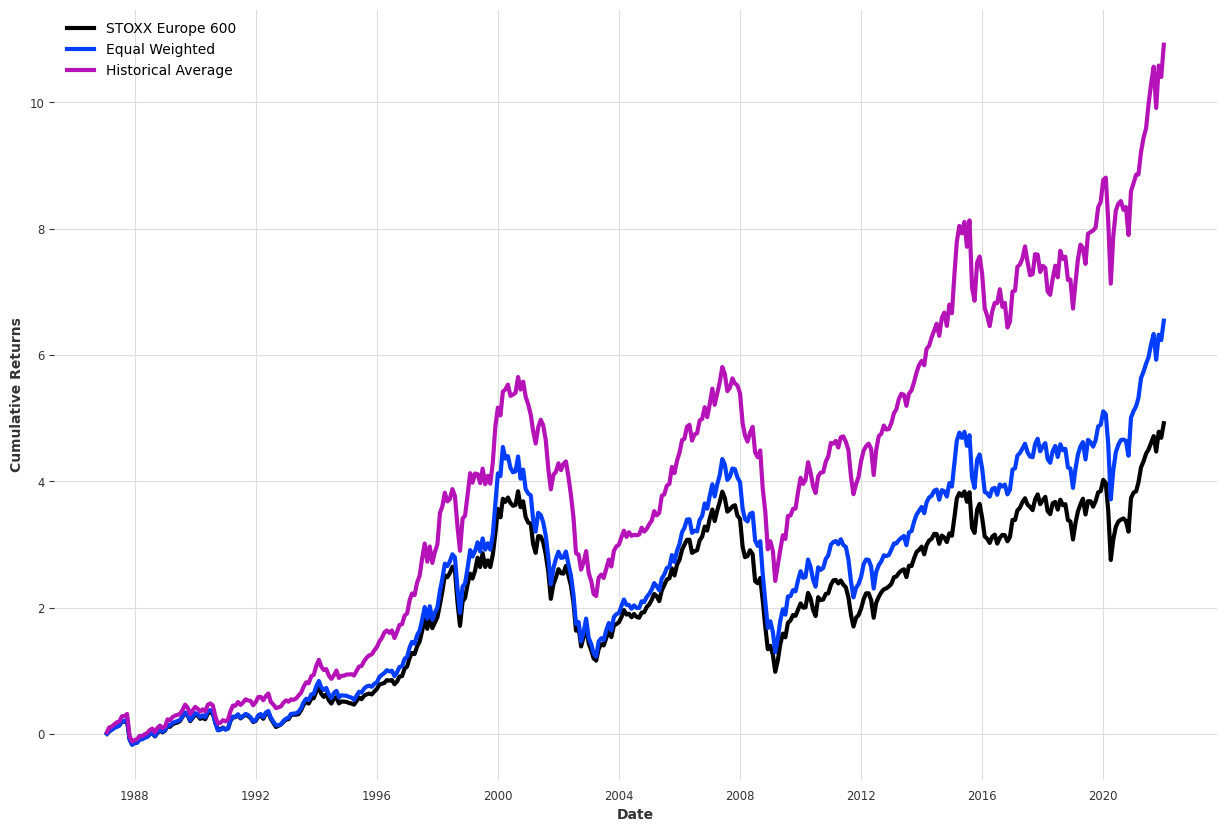

In [12]:
# plot the cumulative returns of the equal weighted portfolio, the STOXX Europe 600 and the historical average portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600', lw=3)
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted', lw=3)
plt.plot(portfolio_returns['historical_average'], label='Historical Average', lw=3)
plt.legend(loc='upper left')
#plt.title('Cumulative Returns of Equal Weighted Portfolio, STOXX Europe 600 and Historical Average Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show();

## Shrinkage Methods

### Linear Regression

In [13]:
# I have tested the model with different lags, which have shown the best results for mape and mse
linear_model_1 = LinearRegressionModel(lags=1, output_chunk_length=1)
linear_model_1.fit(train)
linear_forecast_1 = linear_model_1.predict(len(test))

In [14]:
# backtesting shows the following results

# first linear regression model with 1 lag
hf1_linear_regression = linear_model_1.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.6,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

  0%|          | 0/169 [00:00<?, ?it/s]

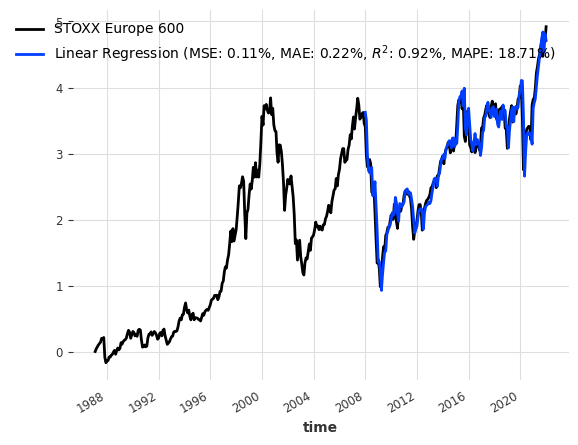

In [15]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_linear_regression['STOXX Europe 600'].plot(label='Linear Regression (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}%, MAPE: {:.2f}%)'.format(mse(hf1_linear_regression, cum_returns), mae(hf1_linear_regression, cum_returns), r2_score(hf1_linear_regression, cum_returns), mape(hf1_linear_regression, cum_returns)))

#### Portfolio

In [16]:
# change the type of the linear_forecast to a pandas dataframe
linear_forecast_1 = linear_forecast_1.pd_dataframe()

In [17]:
# use the pyportfolioopt library to compute the optimal portfolio 
# perform mean-variance optimization with the linear regression forecast
mu_linear_regression_1 = expected_returns.mean_historical_return(linear_forecast_1)
S_linear_regression_1 = risk_models.sample_cov(linear_forecast_1)

In [18]:
# optimize for maximal sharpe ratio for tangency portfolio
ef_linear_regression_1 = EfficientFrontier(mu_linear_regression_1, S_linear_regression_1)
ef_linear_regression_1.add_constraint(lambda w: w[0] == 0)
weights_lr_1 = ef_linear_regression_1.max_sharpe()

In [19]:
# print the weights in a table and round them to 3 decimals
print('Weights for Linear regression: ' + str(np.round(pd.Series(weights_lr_1), 3)))

Weights for Linear regression: STOXX Europe 600    0.000
Banks               0.032
Financials          0.000
Auto & Parts        0.182
Insurance          -0.000
Technology          0.030
Utilities           0.000
Chemicals          -0.000
Basic Resource      0.000
Con & Mat           0.112
Health Care         0.645
Inds Gds & Svs     -0.000
Media               0.000
Telecoms            0.000
dtype: float64


In [20]:
# compute the portfolio return
lr_returns_1 = (cum_returns_portfolio * weights_lr_1).sum(axis=1)
# Add portfolio_returns as a new column in cum_returns
portfolio_returns['linear_regression_1'] = lr_returns_1

In [21]:
# print the portfolio return
print('Last value of the linear regression portfolio: ' + str(np.round(portfolio_returns['linear_regression_1'].iloc[-1], 2)) + '%')

Last value of the linear regression portfolio: 17.05%


### Ridge Regression

In [22]:
# I have tested the model with different lags, which have shown the best results for mape and mse
# ridge regression model with 1 lag of STOXX Europe 600
ridge_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.Ridge(alpha=1))
ridge_model_1.fit(train)
ridge_forecast_1 = ridge_model_1.predict(len(test))

In [23]:
# first ridge regression model with 1 lag
hf1_ridge_regression = ridge_model_1.historical_forecasts(
    series= cum_returns,    # the target time series used to successively train and compute the historical forecasts.
    start= 0.7,             # first point in time at which a prediction is computed for a future time
    forecast_horizon= 1,    # the forecast horizon for the predictions
    verbose= True
)

  0%|          | 0/127 [00:00<?, ?it/s]

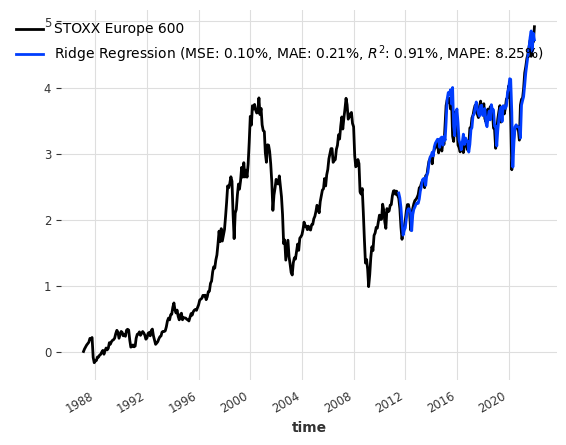

In [24]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_ridge_regression['STOXX Europe 600'].plot(label='Ridge Regression (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}%, MAPE: {:.2f}%)'.format(mse(hf1_ridge_regression, cum_returns), mae(hf1_ridge_regression, cum_returns), r2_score(hf1_ridge_regression, cum_returns), mape(hf1_ridge_regression, cum_returns)))

#### Portfolio

In [25]:
ridge_forecast_1 = ridge_forecast_1.pd_dataframe()

In [26]:
# perform mean-variance optimization with the ridge regression forecast
mu_ridge_regression_1 = expected_returns.mean_historical_return(ridge_forecast_1)
S_ridge_regression_1 = risk_models.sample_cov(ridge_forecast_1)

In [27]:
# optimize for maximal Sharpe ratio
ef_ridge_regression_1 = EfficientFrontier(mu_ridge_regression_1, S_ridge_regression_1)
ef_ridge_regression_1.add_constraint(lambda w: w[0] == 0)
weights_rr_1 = ef_ridge_regression_1.max_sharpe()

In [28]:
# print the weights in a table and round them to 2 decimal places
print('Weights for ridge regression with 1 lag: ' + str(np.round(pd.Series(weights_rr_1), 3)))

Weights for ridge regression with 1 lag: STOXX Europe 600    0.0
Banks               0.0
Financials          0.0
Auto & Parts        0.0
Insurance           0.0
Technology          0.0
Utilities           0.0
Chemicals           0.0
Basic Resource      0.0
Con & Mat           0.0
Health Care         1.0
Inds Gds & Svs      0.0
Media               0.0
Telecoms            0.0
dtype: float64


In [29]:
# calculate the returns of the ridge regression portfolio
rr_returns_1 = (cum_returns_portfolio * weights_rr_1).sum(axis=1)
# save the results
portfolio_returns['ridge_regression_1'] = rr_returns_1


In [30]:
# show the last value of each portfolio and round it to 2 decimal places
print('Last value of the ridge regression portfolio: ' + str(np.round(portfolio_returns['ridge_regression_1'].iloc[-1], 2)) + '%')

Last value of the ridge regression portfolio: 24.1%


### Lasso Regression

In [31]:
# I have tested the model with different lags, which have shown the best results for mape and mse
# lasso regression model with 1 lag of STOXX Europe 600
lasso_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.Lasso(alpha=0))
lasso_model_1.fit(train)
lasso_forecast_1 = lasso_model_1.predict(len(test))

In [32]:
# first lasso regression model with 1 lag
hf1_lasso_regression = lasso_model_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

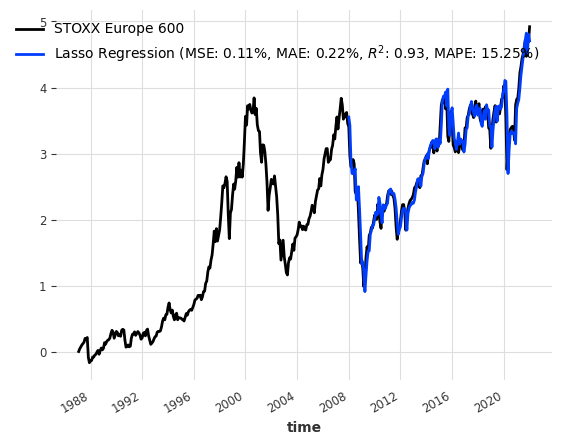

In [33]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_lasso_regression['STOXX Europe 600'].plot(label='Lasso Regression (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}, MAPE: {:.2f}%)'.format(mse(hf1_lasso_regression, cum_returns), mae(hf1_lasso_regression, cum_returns), r2_score(hf1_lasso_regression, cum_returns),mape(hf1_lasso_regression, cum_returns)))

#### Portfolio

In [34]:
lasso_forecast_1 = lasso_forecast_1.pd_dataframe()

In [35]:
# perform mean-variance optimization
mu_lasso_regression_1 = expected_returns.mean_historical_return(lasso_forecast_1)
S_lasso_regression_1 = risk_models.sample_cov(lasso_forecast_1)

In [36]:
# optimize for maximal Sharpe ratio
ef_lasso_regression_1 = EfficientFrontier(mu_lasso_regression_1, S_lasso_regression_1)
ef_lasso_regression_1.add_constraint(lambda w: w[0] == 0)
weights_lar_1 = ef_lasso_regression_1.max_sharpe()

In [37]:
# print the weights in a table and round them to 4 decimals
print('Weights for lasso regression with 1 lag: ' + str(np.round(pd.Series(weights_lar_1), 3)))

Weights for lasso regression with 1 lag: STOXX Europe 600    0.000
Banks               0.000
Financials          0.000
Auto & Parts        0.000
Insurance           0.000
Technology          0.023
Utilities           0.000
Chemicals           0.000
Basic Resource      0.108
Con & Mat           0.000
Health Care         0.869
Inds Gds & Svs      0.000
Media               0.000
Telecoms            0.000
dtype: float64


In [38]:
# compute the returns of lasso regression portfolio
lar_returns_1 = (cum_returns_portfolio * weights_lar_1).sum(axis=1)
# save the returns
portfolio_returns['lasso_regression_1'] = lar_returns_1

In [39]:
# show the last value of each portfolio and round it to 2 decimal places
print('Last value of the lasso regression portfolio: ' + str(np.round(portfolio_returns['lasso_regression_1'].iloc[-1], 2)) + '%')

Last value of the lasso regression portfolio: 21.88%


### Bayesian Regression

In [40]:
bayesian_model_1 = RegressionModel(lags=1, model=sklearn.linear_model.BayesianRidge())
bayesian_model_1.fit(train)
bayesian_forecast_1 = bayesian_model_1.predict(len(test))

In [41]:
hf1_bayesian = bayesian_model_1.historical_forecasts(series=cum_returns, start=0.7, forecast_horizon=1, verbose=True)

  0%|          | 0/127 [00:00<?, ?it/s]

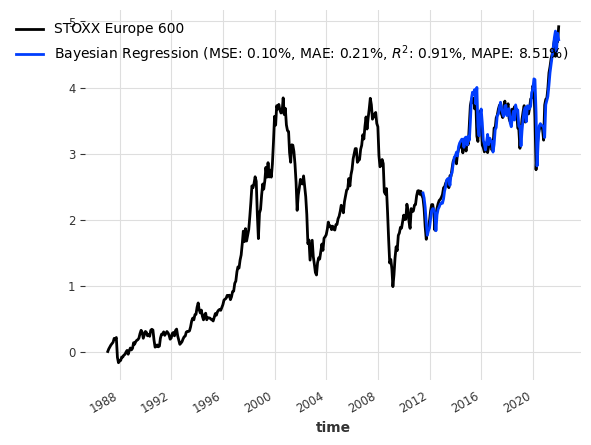

In [42]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_bayesian['STOXX Europe 600'].plot(label='Bayesian Regression (MSE: {:.2f}%, MAE: {:.2f}%, $R^2$: {:.2f}%, MAPE: {:.2f}%)'.format(mse(hf1_bayesian, cum_returns), mae(hf1_bayesian, cum_returns), r2_score(hf1_bayesian, cum_returns), mape(hf1_bayesian, cum_returns)))

##### Portfolio

In [43]:
bayesian_forecast_1 = bayesian_forecast_1.pd_dataframe()

In [44]:
# perform mean-variance optimization with the ridge regression forecast
mu_bayesian_1 = expected_returns.mean_historical_return(bayesian_forecast_1)
S_bayesian_1 = risk_models.sample_cov(bayesian_forecast_1)

In [45]:
# optimize for maximal Sharpe ratio
ef_bayesian_1 = EfficientFrontier(mu_bayesian_1, S_bayesian_1)
ef_bayesian_1.add_constraint(lambda w: w[0] == 0)
weights_bayesian_1 = ef_bayesian_1.max_sharpe()

In [46]:
# print the weights in a table and round them to 2 decimal places
print('Weights for Bayesian regression with 1 lag: ' + str(np.round(pd.Series(weights_bayesian_1), 3)))

Weights for Bayesian regression with 1 lag: STOXX Europe 600    0.000
Banks               0.000
Financials          0.000
Auto & Parts        0.000
Insurance           0.000
Technology          0.002
Utilities           0.000
Chemicals           0.142
Basic Resource      0.000
Con & Mat           0.000
Health Care         0.857
Inds Gds & Svs      0.000
Media              -0.000
Telecoms            0.000
dtype: float64


In [47]:
# calculate the return and volatility of the portfolio
br_returns_1 = (cum_returns_portfolio * weights_bayesian_1).sum(axis=1)

portfolio_returns['Bayesian Regression'] = br_returns_1

In [48]:
# show the last value of the portfolio
print('The last value of the Bayesian Regression portfolio is: ' + str(round(portfolio_returns['Bayesian Regression'].iloc[-1], 2)) + '%')

The last value of the Bayesian Regression portfolio is: 22.55%


# Analysis Shrinkage

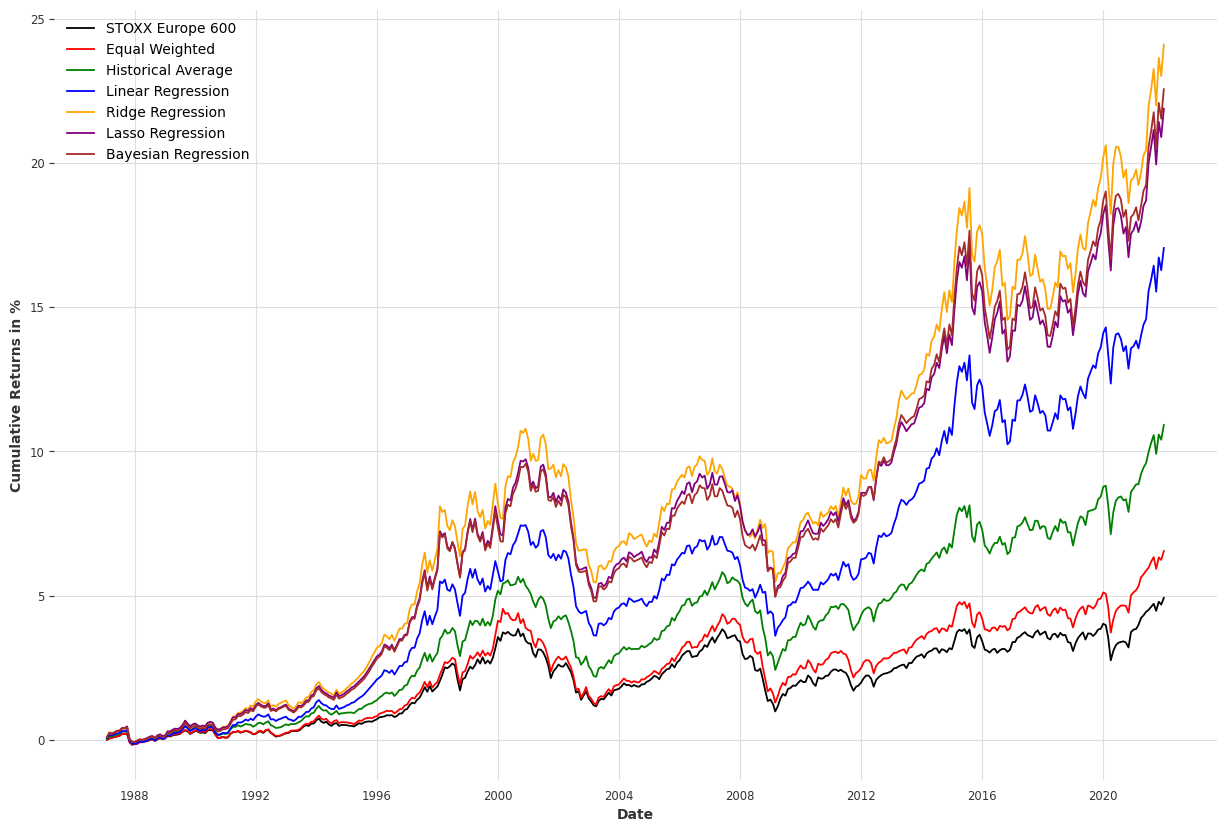

In [49]:
# plot all the cumulative returns
plt.figure(figsize=(15,10))

plt.plot(cum_returns_portfolio['STOXX Europe 600'], color= 'black', label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], color= 'red', label='Equal Weighted')
plt.plot(portfolio_returns['historical_average'], color= 'green', label='Historical Average')
plt.plot(portfolio_returns['linear_regression_1'], color= 'blue', label='Linear Regression')
plt.plot(portfolio_returns['ridge_regression_1'], color= 'orange', label='Ridge Regression')
plt.plot(portfolio_returns['lasso_regression_1'], color= 'purple', label='Lasso Regression')
plt.plot(portfolio_returns['Bayesian Regression'], color= 'brown', label='Bayesian Regression')

plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns in %')

plt.show();

In [50]:
# generate a table containing the return and volatility for all models
performance = {
    'Portfolio': ['STOXX Europe 600', 'Equal Weighted Portfolio', 'Historical Average Portfolio', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Bayesian Regression'],
    'Return': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0], 
              portfolio_returns['equal_weighted'].tail(1).values[0], 
              portfolio_returns['historical_average'].tail(1).values[0],
              portfolio_returns['linear_regression_1'].tail(1).values[0],
                portfolio_returns['ridge_regression_1'].tail(1).values[0],
                portfolio_returns['lasso_regression_1'].tail(1).values[0],
                portfolio_returns['Bayesian Regression'].tail(1).values[0]],
    'Volatility': [cum_returns_portfolio['STOXX Europe 600'].std(),
                    portfolio_returns['equal_weighted'].std(),
                    portfolio_returns['historical_average'].std(),
                    portfolio_returns['linear_regression_1'].std(),
                portfolio_returns['ridge_regression_1'].std(),
                portfolio_returns['lasso_regression_1'].std(),
                portfolio_returns['Bayesian Regression'].std()]
}

# Create a DataFrame from the dictionary
performance = pd.DataFrame(performance)

# Set the index of the DataFrame to be the Portfolio column
performance.set_index('Portfolio', inplace=True)

# divide the values by 100 to get the percentage
performance[['Return', 'Volatility']] = performance[['Return', 'Volatility']].div(100)

# Format the DataFrame to display the values as percentages with only 2 decimal places
performance.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
STOXX Europe 600,4.92%,1.31%
Equal Weighted Portfolio,6.54%,1.63%
Historical Average Portfolio,10.91%,2.67%
Linear Regression,17.05%,4.25%
Ridge Regression,24.10%,6.03%
Lasso Regression,21.88%,5.44%
Bayesian Regression,22.55%,5.62%


In [51]:
# convert portfolio returns as pandas.core.Series to a darts.timeseries.TimeSeries
# save portfolio returns as a csv file
portfolio_returns.to_csv('data/portfolio_returns_shrinkage.csv', index=True, header=True)

# get portfolio returns from csv file as TimeSeries
portfolio_returns_timeseries = TimeSeries.from_csv('data/portfolio_returns_shrinkage.csv', index_col=0, parse_dates=True)

In [52]:
# create a table that includes the mape, mse, and r2 score for each portfolio
evaluation = {
    'Portfolio': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Bayesian Regression'], 
    'MSE': [mse(hf1_linear_regression, cum_returns),
            mse(hf1_ridge_regression, cum_returns),
            mse(hf1_lasso_regression, cum_returns),
            mse(hf1_bayesian, cum_returns)],
    'MAE': [mae(hf1_linear_regression, cum_returns),
            mae(hf1_ridge_regression, cum_returns),
            mae(hf1_lasso_regression, cum_returns),
            mae(hf1_bayesian, cum_returns)],
    'R2': [r2_score(hf1_linear_regression, cum_returns),
                 r2_score(hf1_ridge_regression, cum_returns),
                 r2_score(hf1_lasso_regression, cum_returns),
                 r2_score(hf1_bayesian, cum_returns)],
    'MAPE': [mape(hf1_linear_regression, cum_returns), 
             mape(hf1_ridge_regression, cum_returns), 
             mape(hf1_lasso_regression, cum_returns), 
             mape(hf1_bayesian, cum_returns)],
}

# Create a DataFrame from the dictionary
evaluation = pd.DataFrame(evaluation)

# Set the index of the DataFrame to be the Portfolio column
evaluation.set_index('Portfolio', inplace=True)

# Divide the values by 100 to get the percentage
evaluation[['MSE', 'MAE', 'R2', 'MAPE']] = evaluation[['MSE', 'MAE', 'R2', 'MAPE']].div(100)

# Format the DataFrame to display the values as percentages
evaluation.style.format("{:.2%}")

,MSE,MAE,R2,MAPE
Portfolio,,,,
Linear Regression,0.11%,0.22%,0.92%,18.71%
Ridge Regression,0.10%,0.21%,0.91%,8.25%
Lasso Regression,0.11%,0.22%,0.93%,15.25%
Bayesian Regression,0.10%,0.21%,0.91%,8.51%


In [53]:
# save this dataframe as a csv file
evaluation.to_csv('data/evaluation_shrinkage.csv', index=True, header=True)